# UofT 3456 Deep Learning Final Project

For this project I used the APTOS 2019 Blindness Detection dataset from Kaggle.

The purpose of this project is be able to look at retinal scans, and determine the severity of diabetic retinopathy. Diabetic retinopathy is a disease can cause blindess as a result of having diabetes. The interesting thing about the retina scans, is you can determine the severity, and if the indicators are present, it can be managed with treatment and focusing on managing the impact of diabetes.

In this project, I'll look at the data, and test various CNN models, utilizing transfer learning with available architectures in Keras. 

The training data are images with a label as to how serious the diabetic retinopathy is for the given eye scan image. Rather than using the testing data (due to the lack of labels), I split the training data into training and validation data and made my conclusions based on that. To train the data, I ran portions of my code on my local machine and portions of it were run on Kaggle. 

In this notebook, I test various different possible fully connected network options. I will also include the overall results below and some learnings. In the other notebooks, I take similar steps to the ones here, except apply different pre-trained architectures for transfer learning.

## Results

Overall, the results of the different architectures were as follows:

Model | Validation Accuracy | Accuracy
---|---|---
VGG16 | 70.4% | 68.7%
VGG19 | 70.2% | 68.9%
VGG19 (greyscale) | 71.8% | 69.3%
Xception | 59.4% | 74.1%
ResNet50 | 46% | 75.8%
DenseNet121 | 52.5% | 72.1%

All of the above had a fully connected layer with 2 layers: one Dense with 256 nodes and ReLu activation and the other Dense with 5 nodes and softmax activation. The only one that used different images was the VGG 19 which used the data in greyscale.

Overall, the best performing model was the VGG19 (greyscale). This is based on the validation accuracy. Initially, going in, the expectation was that the VGG models would be outperformed by the other models. However, this turned out not to be the case. With the: Xception, ResNet and DenseNet models, we found that the models were significantly overfitting. This is something that could be corrected in the future by adding some regularization. 

One of the interesting learnings from this process was the idea of converting the images into greyscale. This was suggested by a former winner of the competition Ben Graham. This idea is interested because, normally, when we are performing data augmentation, we look to do things like change the sizing or position. However, converting these retinal scans to greyscale in fact increased the contrast between different features of the scans. This ended up leading to an approximately 2% boost to the model's accuracy. I referred to the following Kaggle Kernel for more insight into the preprocessing methods: https://www.kaggle.com/ratthachat/aptos-eye-preprocessing-in-diabetic-retinopathy.

 


## Testing Fully Connected Layers

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os


In [2]:
# other imports/set up
import keras
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.applications.vgg16 import vgg16

Using TensorFlow backend.


In [3]:
# import the data and specify the paths
sample_submission = pd.read_csv("sample_submission.csv")
test = "test_images"
train = "train_images"
df_test = pd.read_csv("test.csv")
df_train = pd.read_csv("train.csv")

In [4]:
# look at the info of the training data
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3662 entries, 0 to 3661
Data columns (total 2 columns):
id_code      3662 non-null object
diagnosis    3662 non-null int64
dtypes: int64(1), object(1)
memory usage: 57.3+ KB


In [5]:
# look at the head of the training data
df_train.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [6]:
# the following bit of code was taken from
# https://www.kaggle.com/carlolepelaars/efficientnetb5-with-keras-aptos-2019
print("Image IDs and Labels (TRAIN)")
# Add extension to id_code
df_train['id_code'] = df_train['id_code'] + ".png"
print(f"Training images: {df_train.shape[0]}")
display(df_train.head())
print("Image IDs (TEST)")
# Add extension to id_code
df_test['id_code'] = df_test['id_code'] + ".png"
print(f"Testing Images: {df_test.shape[0]}")
display(df_test.head())

Image IDs and Labels (TRAIN)
Training images: 3662


,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


Image IDs (TEST)
Testing Images: 1928


,id_code
0,0005cfc8afb6.png
1,003f0afdcd15.png
2,006efc72b638.png
3,00836aaacf06.png
4,009245722fa4.png


In [10]:
# image data generators
# data augmentations was applied here
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   validation_split=0.2,
                                  rotation_range=360,
                                  horizontal_flip=True,
                                  vertical_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
# train generator
train_generator = train_datagen.flow_from_dataframe(df_train,
                                                    x_col='id_code', 
                                                    y_col='diagnosis', 
                                                    directory=train, 
                                                    target_size=(244,244), 
                                                    class_mode='raw',
                                                   subset='training')

# validation generator
val_generator = train_datagen.flow_from_dataframe(df_train,
                                                 x_col='id_code',
                                                 y_col='diagnosis',
                                                 directory=train,
                                                 target_size=(244,244),
                                                 class_mode='raw',
                                                 subset='validation')


Found 2930 validated image filenames.
Found 732 validated image filenames.


Now we have the training data, and the validation data, which will be the test data split and have the generators ready. What we want to do now is look at different top layers that we can add to pretrained models. By testing our top layers and disabling the training for the VGG model, we can compare the performance of the different top layers. The architecture that is used here can then be applied to the different CNN architectures in order to determine which one is best suited for this task. 

In [12]:
# load the VGG model with keras, using imagenet weights and excluding the top layer
model_vgg16 = keras.applications.vgg16.VGG16(include_top=False, weights='imagenet',input_shape=(244,244,3))

In [13]:
# summary of the VGG model
model_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 244, 244, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 244, 244, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 244, 244, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 122, 122, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 122, 122, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 122, 122, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 61, 61, 128)       0     

In [14]:
for layers in model_vgg16.layers:
    layers.trainable = False

Model 1: 2 Layers: Dense (256 Relu, 5 Softmax) with Dropout

In [15]:
model = Sequential()
for i in model_vgg16.layers:
    model.add(i)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 244, 244, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 244, 244, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 122, 122, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 122, 122, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 122, 122, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 61, 61, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 61, 61, 256)      

In [16]:
#callbacks = [EarlyStopping(monitor='val_loss', patience=1),
#            ModelCheckpoint(filepath="bestmodel.h5", monitor='val_loss', save_best_only=True)]

In [17]:
model.compile(loss='sparse_categorical_crossentropy',
             optimizer=keras.optimizers.Adam(),
             metrics=['accuracy'])

In [18]:
history = model.fit_generator(train_generator,
                             epochs=5,
                             validation_data=val_generator,
                             verbose=1)

Epoch 1/5
92/92 [==============================] - 1724s 19s/step - loss: 1.4254 - accuracy: 0.6020 - val_loss: 1.2068 - val_accuracy: 0.6721
Epoch 2/5
92/92 [==============================] - 1211s 13s/step - loss: 0.9619 - accuracy: 0.6560 - val_loss: 0.9341 - val_accuracy: 0.6776
Epoch 3/5
92/92 [==============================] - 1213s 13s/step - loss: 0.9285 - accuracy: 0.6812 - val_loss: 0.8830 - val_accuracy: 0.6913
Epoch 4/5
92/92 [==============================] - 1208s 13s/step - loss: 0.9250 - accuracy: 0.6795 - val_loss: 0.9068 - val_accuracy: 0.6967
Epoch 5/5
92/92 [==============================] - 1222s 13s/step - loss: 0.9031 - accuracy: 0.6819 - val_loss: 0.6792 - val_accuracy: 0.6776


In [19]:
history.history

{'val_loss': [1.2068328857421875,
  0.9340629577636719,
  0.8830280303955078,
  0.9068112969398499,
  0.679193377494812],
 'val_accuracy': [0.6721311211585999,
  0.6775956153869629,
  0.6912568211555481,
  0.6967213153839111,
  0.6775956153869629],
 'loss': [1.4270028852358614,
  0.9624100532548012,
  0.929661717471816,
  0.9240265960986297,
  0.9042535197205918],
 'accuracy': [0.6020478, 0.6559727, 0.6812287, 0.67952216, 0.6819113]}

In [20]:
def train_validation_loss_plot():
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(loss) + 1)
    
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    return plt.show()

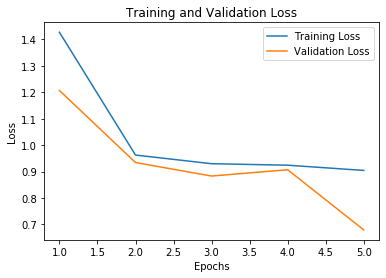

In [21]:
train_validation_loss_plot()

In [22]:
def train_validation_accuracy_plot():
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    epochs = range(1, len(acc) + 1)
    
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    return plt.show()

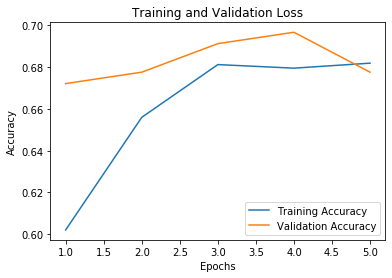

In [23]:
train_validation_accuracy_plot()

Model 2: 3 Layers: Dense (256 Relu, 64 Relu, 5 Softmax) with Dropout

In [24]:
model_2 = Sequential()
for i in model_vgg16.layers:
    model_2.add(i)
model_2.add(Flatten())
model_2.add(Dense(256, activation='relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(64, activation='relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(5, activation='softmax'))
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 244, 244, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 244, 244, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 122, 122, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 122, 122, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 122, 122, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 61, 61, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 61, 61, 256)      

In [25]:
model_2.compile(loss='sparse_categorical_crossentropy',
             optimizer=keras.optimizers.Adam(),
             metrics=['accuracy'])

In [26]:
history_2 = model_2.fit_generator(train_generator,
                             epochs=5,
                             validation_data=val_generator,
                             verbose=1)

Epoch 1/5
92/92 [==============================] - 1225s 13s/step - loss: 1.5279 - accuracy: 0.4881 - val_loss: 1.0763 - val_accuracy: 0.6352
Epoch 2/5
92/92 [==============================] - 1217s 13s/step - loss: 1.0426 - accuracy: 0.6273 - val_loss: 1.0420 - val_accuracy: 0.6790
Epoch 3/5
92/92 [==============================] - 1211s 13s/step - loss: 1.0182 - accuracy: 0.6495 - val_loss: 1.1692 - val_accuracy: 0.6790
Epoch 4/5
92/92 [==============================] - 1216s 13s/step - loss: 0.9627 - accuracy: 0.6696 - val_loss: 0.9960 - val_accuracy: 0.6598
Epoch 5/5
92/92 [==============================] - 1214s 13s/step - loss: 0.9721 - accuracy: 0.6628 - val_loss: 1.0658 - val_accuracy: 0.6803


In [27]:
history_2.history

{'val_loss': [1.0763206481933594,
  1.0419516563415527,
  1.1692389249801636,
  0.995951235294342,
  1.0657553672790527],
 'val_accuracy': [0.6352459192276001,
  0.6789617538452148,
  0.6789617538452148,
  0.6598360538482666,
  0.6803278923034668],
 'loss': [1.531405343130587,
  1.04135935249589,
  1.0186247106705102,
  0.9638351093786975,
  0.9717011937509218],
 'accuracy': [0.4880546, 0.6273038, 0.64948803, 0.66962457, 0.66279864]}

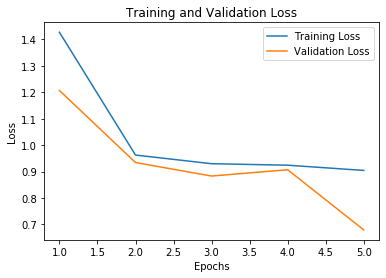

In [28]:
train_validation_loss_plot()

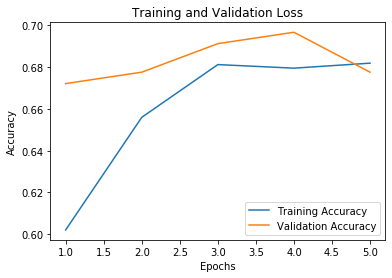

In [29]:
train_validation_accuracy_plot()

Model 3: 2 Layers: Dense (64 Relu, 5 Softmax) with Dropout

In [30]:
model_3 = Sequential()
for i in model_vgg16.layers:
    model_3.add(i)
model_3.add(Flatten())
model_3.add(Dense(64, activation='relu'))
model_3.add(Dropout(0.5))
model_3.add(Dense(5, activation='softmax'))
model_3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 244, 244, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 244, 244, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 122, 122, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 122, 122, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 122, 122, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 61, 61, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 61, 61, 256)      

In [31]:
model_3.compile(loss='sparse_categorical_crossentropy',
             optimizer=keras.optimizers.Adam(),
             metrics=['accuracy'])

In [32]:
history_3 = model_3.fit_generator(train_generator,
                             epochs=5,
                             validation_data=val_generator,
                             verbose=1)

Epoch 1/5
92/92 [==============================] - 1219s 13s/step - loss: 1.2299 - accuracy: 0.5580 - val_loss: 0.9827 - val_accuracy: 0.4795
Epoch 2/5
92/92 [==============================] - 1268s 14s/step - loss: 1.0842 - accuracy: 0.6133 - val_loss: 1.1616 - val_accuracy: 0.5451
Epoch 3/5
92/92 [==============================] - 1203s 13s/step - loss: 1.0531 - accuracy: 0.6304 - val_loss: 0.9051 - val_accuracy: 0.6872
Epoch 4/5
92/92 [==============================] - 1195s 13s/step - loss: 1.0211 - accuracy: 0.6543 - val_loss: 1.0261 - val_accuracy: 0.6585
Epoch 5/5
92/92 [==============================] - 1197s 13s/step - loss: 1.0268 - accuracy: 0.6556 - val_loss: 0.9995 - val_accuracy: 0.6954


In [33]:
history_3.history

{'val_loss': [0.9826759099960327,
  1.1615804433822632,
  0.9051329493522644,
  1.0261335372924805,
  0.9994664788246155],
 'val_accuracy': [0.4795081913471222,
  0.5450819730758667,
  0.687158465385437,
  0.6584699749946594,
  0.6953551769256592],
 'loss': [1.2299437781649645,
  1.0847674764870783,
  1.0551458185036435,
  1.0201608654582053,
  1.0259001541463182],
 'accuracy': [0.5580205, 0.6133106, 0.63037544, 0.65426624, 0.6556314]}

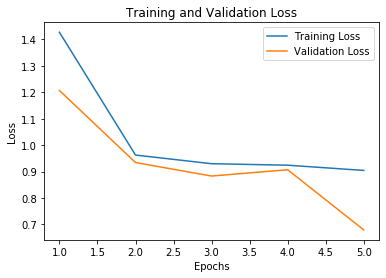

In [34]:
train_validation_loss_plot()

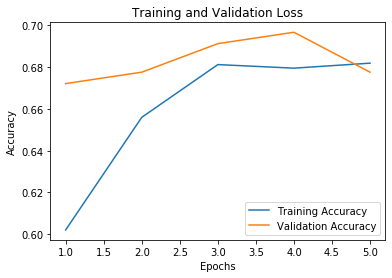

In [35]:
train_validation_accuracy_plot()

Model 4: 2 Layers: Dense (32 Relu, 5 Softmax) with Dropout

In [36]:
model_4 = Sequential()
for i in model_vgg16.layers:
    model_4.add(i)
model_4.add(Flatten())
model_4.add(Dense(32, activation='relu'))
model_4.add(Dropout(0.5))
model_4.add(Dense(5, activation='softmax'))
model_4.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 244, 244, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 244, 244, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 122, 122, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 122, 122, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 122, 122, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 61, 61, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 61, 61, 256)      

In [37]:
model_4.compile(loss='sparse_categorical_crossentropy',
             optimizer=keras.optimizers.Adam(),
             metrics=['accuracy'])

In [38]:
history_4 = model_4.fit_generator(train_generator,
                             epochs=5,
                             validation_data=val_generator,
                             verbose=1)

Epoch 1/5
92/92 [==============================] - 1215s 13s/step - loss: 1.2711 - accuracy: 0.5041 - val_loss: 1.2247 - val_accuracy: 0.5847
Epoch 2/5
92/92 [==============================] - 1201s 13s/step - loss: 1.1534 - accuracy: 0.5638 - val_loss: 1.1519 - val_accuracy: 0.6694
Epoch 3/5
92/92 [==============================] - 1198s 13s/step - loss: 1.1361 - accuracy: 0.5734 - val_loss: 1.0479 - val_accuracy: 0.6844
Epoch 4/5
92/92 [==============================] - 1198s 13s/step - loss: 1.1139 - accuracy: 0.5799 - val_loss: 1.0399 - val_accuracy: 0.6899
Epoch 5/5
92/92 [==============================] - 1199s 13s/step - loss: 1.1468 - accuracy: 0.5614 - val_loss: 0.3916 - val_accuracy: 0.6434


In [39]:
history_4.history

{'val_loss': [1.2246562242507935,
  1.1518723964691162,
  1.0479391813278198,
  1.039853572845459,
  0.3916439712047577],
 'val_accuracy': [0.5846994519233704,
  0.6693989038467407,
  0.6844262480735779,
  0.6898906826972961,
  0.6434426307678223],
 'loss': [1.2712561459264657,
  1.1523627733614665,
  1.135026645741772,
  1.112795543019682,
  1.1469375858534725],
 'accuracy': [0.50409555, 0.5638225, 0.57337886, 0.5798635, 0.56143343]}

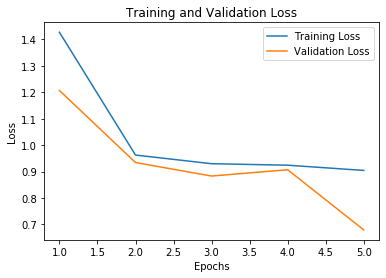

In [40]:
train_validation_loss_plot()

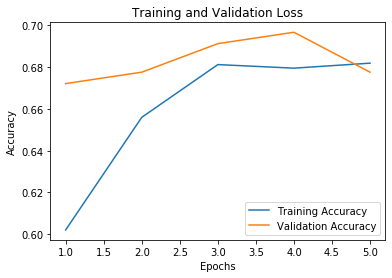

In [41]:
train_validation_accuracy_plot()

Model 5: 3 Layers: Dense (128 Relu, 32 Relu, 5 Softmax) with Dropout

In [42]:
model_5 = Sequential()
for i in model_vgg16.layers:
    model_5.add(i)
model_5.add(Flatten())
model_5.add(Dense(128, activation='relu'))
model_5.add(Dropout(0.5))
model_5.add(Dense(32, activation='relu'))
model_5.add(Dropout(0.5))
model_5.add(Dense(5, activation='softmax'))
model_5.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 244, 244, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 244, 244, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 122, 122, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 122, 122, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 122, 122, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 61, 61, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 61, 61, 256)      

In [43]:
model_5.compile(loss='sparse_categorical_crossentropy',
             optimizer=keras.optimizers.Adam(),
             metrics=['accuracy'])

In [44]:
history_5 = model_5.fit_generator(train_generator,
                             epochs=5,
                             validation_data=val_generator,
                             verbose=1)

Epoch 1/5
92/92 [==============================] - 1217s 13s/step - loss: 1.4951 - accuracy: 0.4150 - val_loss: 1.0515 - val_accuracy: 0.4604
Epoch 2/5
92/92 [==============================] - 1201s 13s/step - loss: 1.1570 - accuracy: 0.5154 - val_loss: 1.0059 - val_accuracy: 0.6612
Epoch 3/5
92/92 [==============================] - 1203s 13s/step - loss: 1.1402 - accuracy: 0.5737 - val_loss: 1.0256 - val_accuracy: 0.6694
Epoch 4/5
92/92 [==============================] - 1202s 13s/step - loss: 1.1132 - accuracy: 0.6024 - val_loss: 0.8066 - val_accuracy: 0.6653
Epoch 5/5
92/92 [==============================] - 1202s 13s/step - loss: 1.0583 - accuracy: 0.6188 - val_loss: 0.8605 - val_accuracy: 0.6653


In [45]:
history_5.history

{'val_loss': [1.0514639616012573,
  1.0059216022491455,
  1.0255825519561768,
  0.8065561056137085,
  0.8604770302772522],
 'val_accuracy': [0.46038252115249634,
  0.6612021923065186,
  0.6693989038467407,
  0.6653005480766296,
  0.6653005480766296],
 'loss': [1.4941298179659013,
  1.1574524944552789,
  1.1414092534231244,
  1.1120941578731602,
  1.05763100471106],
 'accuracy': [0.41501707, 0.5153584, 0.57372016, 0.6023891, 0.6187713]}

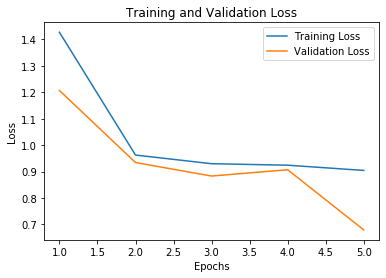

In [46]:
train_validation_loss_plot()

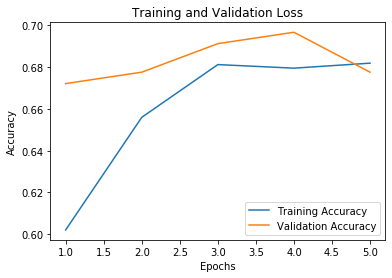

In [47]:
train_validation_accuracy_plot()

Model 6: 2 Layers: Dense (128 Relu, 5 Softmax) with Dropout

In [48]:
model_6 = Sequential()
for i in model_vgg16.layers:
    model_6.add(i)
model_6.add(Flatten())
model_6.add(Dense(128, activation='relu'))
model_6.add(Dropout(0.5))
model_6.add(Dense(5, activation='softmax'))
model_6.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 244, 244, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 244, 244, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 122, 122, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 122, 122, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 122, 122, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 61, 61, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 61, 61, 256)      

In [49]:
model_6.compile(loss='sparse_categorical_crossentropy',
             optimizer=keras.optimizers.Adam(),
             metrics=['accuracy'])

In [50]:
history_6 = model_6.fit_generator(train_generator,
                             epochs=5,
                             validation_data=val_generator,
                             verbose=1)

Epoch 1/5
92/92 [==============================] - 1222s 13s/step - loss: 1.2121 - accuracy: 0.5904 - val_loss: 0.8531 - val_accuracy: 0.6721
Epoch 2/5
92/92 [==============================] - 1203s 13s/step - loss: 0.9959 - accuracy: 0.6597 - val_loss: 0.8282 - val_accuracy: 0.6694
Epoch 3/5
92/92 [==============================] - 1204s 13s/step - loss: 0.9537 - accuracy: 0.6717 - val_loss: 0.8759 - val_accuracy: 0.6899
Epoch 4/5
92/92 [==============================] - 1202s 13s/step - loss: 0.9325 - accuracy: 0.6840 - val_loss: 0.8785 - val_accuracy: 0.6858
Epoch 5/5
92/92 [==============================] - 1199s 13s/step - loss: 0.9208 - accuracy: 0.6809 - val_loss: 0.8570 - val_accuracy: 0.6872


In [51]:
history_6.history

{'val_loss': [0.8531011343002319,
  0.8281804323196411,
  0.8759039044380188,
  0.8784742951393127,
  0.8569619059562683],
 'val_accuracy': [0.6721311211585999,
  0.6693989038467407,
  0.6898906826972961,
  0.6857923269271851,
  0.687158465385437],
 'loss': [1.2150697785432836,
  0.9955573127538271,
  0.9545710047357319,
  0.9304785841561015,
  0.9197628116444923],
 'accuracy': [0.5904437, 0.659727, 0.67167234, 0.68395907, 0.6808874]}

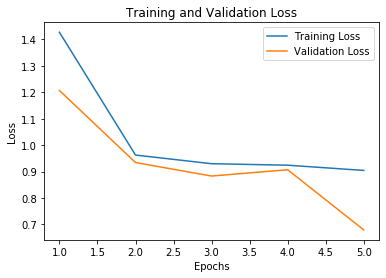

In [52]:
train_validation_loss_plot()

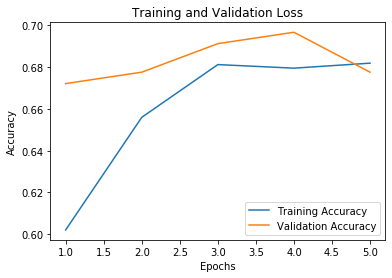

In [53]:
train_validation_accuracy_plot()

Model Number | Layer Details| Accuracy | Validation Accuracy
--- | --- | --- | ---
1 | 2 Dense Layers (256,5) | 66% | 68.4%
2 | 3 Dense Layers (256, 64, 5) | 66.8% | 62%
3 | 2 Dense Layers (64, 5) | 61.6% | 62%
4 | 2 Dense Layers (32, 5) | 65.2% | 55.4%
5 | 3 Dense Layers (128, 32, 5) | 62.6% | 54.2%
6 | 2 Dense Layers (128, 5) | 68.2% | 65.6%


All of the above used: 0.5 Dropout, ReLu for Dense Layers and, Softmax for the output layer.

